# Train Machine Learning Models with Genomics + Clinical Data 

In this sample notebook, we combined the genomics data from 1000 Genome project and simulated clinical data for training of two predictive machine learning models WITH PUBLIC libraries. We focused to explore the phenotype prediction and association finding models with this combined dataset. 
We split the input training data into training and test datasets. After training the models on the training dataset, we demonstrated the results and performance of the models on the test in the last section ("Data Visualization").  
We take multi-sample VCF files for genomic data and TAB-delimited TXT files for clinical data and phenotype data.
There are a few major steps to this process:

1) Genotype Filtering  

2) Formatting filtered genotype data to be combined with the clinical data  

3) Reading in the clinical data and phenotype data and combining with the genotype data  

4) Train machine learning models  

5) Visualizing results  

### Dependencies:

This notebook requires the following libraries:

Azure CLI

AzCopy: Please install latest release of the AzCopy: https://docs.microsoft.com/en-us/azure/storage/common/storage-use-azcopy-v10

bcftools: Utilities for variant calling and manipulating VCFs and BCFs from https://samtools.github.io/bcftools/bcftools.html

Genome Analysis Toolkit (GATK) (Users need to download GATK from Broad Institute's webpage into the same compute environment with this notebook: https://github.com/broadinstitute/gatk/releases)

Users need to download the genomics data from that [link](ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz) and simulated phenotypic datasets from that [link](https://storeshare.blob.core.windows.net/publicdata/simulated_phenotypic.zip)

Important information: This notebook is using Python 3.6 kernel



### Genotype Filtering

First we index the variants recorded in the VCF file:

In [ ]:
!./gatk-4.1.7.0/gatk IndexFeatureFile -I ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz

Filter variants based on minor allele frequencies below 1%. Due to the low number of samples we have in this genotype data, going below (e.g. 1%) limit would make finding statistical associations more difficult:

In [2]:
!bcftools view -q 0.1:minor ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz -o chr22FMAF.vcf

In [3]:
!bcftools query --print-header -f '%CHROM\t%POS\t%TYPE\t%AF\t%REF\t%ALT[\t%GT]\n' chr22FMAF.vcf -o tableChr22FilteredMAF.tsv

In [27]:
import pandas as pd
import sys
import warnings
warnings.simplefilter("ignore")
# Read the table created above into a pandas dataframe:
DF=pd.read_csv("tableChr22FilteredMAF.tsv", delimiter="\t")
DF.head(5)

,# [1]CHROM,[2]POS,[3]TYPE,[4]AF,[5]REF,[6]ALT,[7]HG00096:GT,[8]HG00097:GT,[9]HG00099:GT,[10]HG00100:GT,...,[2501]NA21128:GT,[2502]NA21129:GT,[2503]NA21130:GT,[2504]NA21133:GT,[2505]NA21135:GT,[2506]NA21137:GT,[2507]NA21141:GT,[2508]NA21142:GT,[2509]NA21143:GT,[2510]NA21144:GT
0,22,16051249,SNP,0.11242,T,C,0|0,1|0,1|0,0|0,...,1|0,0|1,1|1,0|0,1|0,0|0,1|0,0|1,1|1,0|0
1,22,16052080,SNP,0.141174,G,A,0|1,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,1|0,0|1,0|0,0|0,0|0
2,22,16052167,INDEL,0.472644,A,AAAAC,0|1,0|0,0|0,1|0,...,0|1,1|1,0|0,0|0,1|1,1|1,0|1,1|1,0|0,1|1
3,22,16053659,SNP,0.857628,A,C,1|0,1|0,1|0,1|1,...,1|1,1|1,1|1,0|0,1|1,1|1,1|1,1|1,1|1,1|1
4,22,16053791,SNP,0.165935,C,A,0|0,0|0,0|0,0|1,...,0|0,0|0,0|0,0|1,0|0,0|1,0|0,0|0,0|0,0|1


We perform LD (linkage disequilibrium) pruning in order to get rid of variants that have high covariance. A good point to start is 0.6 r^2 with the default window size (which can be changed with the -w flag). For European populations, 0.2 is the most commonly used r^2 threshold (https://www.biostars.org/p/450661/)

In [5]:
!./bcftools/bcftools +bcftools/plugins/prune.so -m 0.2 chr22FMAF.vcf -Ob -o chr22FLD.vcf

**Optional:** Can filter based on read depth with the command below (cut-off 20 is used below but can be changed as desired):  
`!bcftools view -i 'MIN(FMT/DP>20)' combined.286LDMAF.vcf`

Upon MAF filtering and LD-pruning, we will turn the genotype data stored in vcf format into a table using bcftools:

In [6]:
!bcftools query --print-header -f '%CHROM\t%POS\t%TYPE\t%AF\t%REF\t%ALT[\t%GT]\n' chr22FLD.vcf -o tableChr22FilteredLD02.tsv

We read the data into a pandas dataframe object in python. Filtering operations with pandas dataframe are much faster than filtering operations gatk carries out on vcf files (at least with the size of the data we currently use), so we will perform the rest of the filtering here:

In [ ]:
import pandas as pd
import sys
import warnings
warnings.simplefilter("ignore")
# Read the table created above into a pandas dataframe:
DF=pd.read_csv("tableChr22FilteredLD02.tsv", delimiter="\t")
DF.head(5)

Split into variant data frame and genotype dataframe, save variant data frame:

In [8]:
DF=DF[~DF.eq("./.").any(1)] #Drop variants with missingness
DF=DF[~(DF["[6]ALT"].str.len()>1)] # Filter out multi-allelic variants, only keep the bi-allelic ones
DF=DF[DF["[3]TYPE"]=="SNP"] # Only keep the SNPs (up to the researcher to set the types). Note: pandas filtering is a lot quicker than GATK.
DF=DF.reset_index(drop=True) #Now that the number of variants (and rows) changed in the dataframe, refresh the indices

variantDF=DF[['# [1]CHROM', '[2]POS', '[3]TYPE', '[4]AF', '[5]REF', '[6]ALT']]
variantDF.columns=["CHROM","POS","TYPE","AF","REF", "ALT"] #Rename the columns
variantDF.to_csv("variantDFChr22.txt", sep="\t") #Variant information saved to a file here
genotypeDF=DF.drop(columns=['# [1]CHROM', '[2]POS', '[3]TYPE', '[4]AF', '[5]REF', '[6]ALT'])

In [29]:
genotypeDF.head(5)

,[7]HG00096:GT,[8]HG00097:GT,[9]HG00099:GT,[10]HG00100:GT,[11]HG00101:GT,[12]HG00102:GT,[13]HG00103:GT,[14]HG00105:GT,[15]HG00106:GT,[16]HG00107:GT,...,[2501]NA21128:GT,[2502]NA21129:GT,[2503]NA21130:GT,[2504]NA21133:GT,[2505]NA21135:GT,[2506]NA21137:GT,[2507]NA21141:GT,[2508]NA21142:GT,[2509]NA21143:GT,[2510]NA21144:GT
0,0|0,1|0,1|0,0|0,0|0,1|0,0|0,0|0,0|1,0|0,...,1|0,0|1,1|1,0|0,1|0,0|0,1|0,0|1,1|1,0|0
1,0|1,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,1|0,...,0|0,0|0,0|0,0|0,0|0,1|0,0|1,0|0,0|0,0|0
2,1|0,1|0,1|0,1|1,1|1,1|0,0|1,0|1,1|1,1|1,...,1|1,1|1,1|1,0|0,1|1,1|1,1|1,1|1,1|1,1|1
3,0|0,0|0,0|0,0|1,0|1,0|0,0|0,0|0,0|0,0|1,...,0|0,0|0,0|0,0|1,0|0,0|1,0|0,0|0,0|0,0|1
4,0|0,0|0,0|0,1|0,1|0,0|0,0|1,0|1,0|0,1|0,...,0|0,1|0,0|0,0|0,0|0,0|1,0|0,1|0,0|0,0|1


Turn haplotype data into genotype data and turn genotype data into a matrix of shape (#individuals, #variants):

### Reading in the Clinical Data

In [10]:
import numpy as np

clinicalData=np.genfromtxt("clinicalData_chr22simu.txt", delimiter="\t")
print("Shape of the clinical data matrix that we read from a TXT file:")
print(clinicalData.shape)

Shape of the clinical data matrix that we read from a TXT file:
(2504, 10)


### Reading in the Phenotype Data:

Define the parameters of the phenotype simulations- [download link](https://storeshare.blob.core.windows.net/publicdata/simulated_phenotypic.zip):

In [11]:
import numpy as np 
N=clinicalData.shape[0] #Total number of samples
quantitativePheno=np.reshape(np.genfromtxt("quantPheno_clinicalgeno_chr22simu.txt", delimiter="\t"),(N,1))
discretePheno=np.reshape(np.genfromtxt("discretePheno_clinicalgeno_chr22simu.txt", delimiter="\t"),(N,1))
causals=np.genfromtxt("causals_clinicalgeno_chr22simu.txt", delimiter="\t")

print("Shape of the quantitative phenotype vector read from TXT file:")
print(quantitativePheno.shape)

print("Shape of the discrete phenotype vector read from TXT file:")
print(discretePheno.shape)

print("Number of ground-truth causal variants (saved during simulations, used for benchmarking later on):")
print(len(causals))

Shape of the quantitative phenotype vector read from TXT file:
(2504, 1)
Shape of the discrete phenotype vector read from TXT file:
(2504, 1)
Number of ground-truth causal variants (saved during simulations, used for benchmarking later on):
176


### Splitting Dataset into Training and Testing Data:

In [12]:
#Set what percent of data will be used in training:
percent_training=0.80

#Based on the parameter set above, determine the number of samples to be used in training:
N=clinicalData.shape[0] #Total number of samples
trainingN=int(N*percent_training)

training_indices=np.arange(0, trainingN)
testing_indices=np.arange(trainingN, N)


genotypeMatrix=np.genfromtxt("genomicChr22.txt", delimiter="\t")
train_genomic=genotypeMatrix[training_indices,]
test_genomic=genotypeMatrix[testing_indices,]

train_clinical=clinicalData[training_indices,]
test_clinical=clinicalData[testing_indices,]

train_quantPheno=quantitativePheno[training_indices,]
test_quantPheno=quantitativePheno[testing_indices,]

train_discretePheno=discretePheno[training_indices,]
test_discretePheno=discretePheno[testing_indices,]

print("Number of samples used for training: ", trainingN)
print("Number of samples used for testing: ", N-trainingN)

################# Save training - test split of datasets #####################
np.savetxt("genomicChr22_training.txt",train_genomic, delimiter="\t")
np.savetxt("genomicChr22_test.txt",test_genomic, delimiter="\t")

np.savetxt("clinicalChr22_training.txt",train_clinical, delimiter="\t")
np.savetxt("clinicalChr22_test.txt",test_clinical, delimiter="\t")

np.savetxt("quantPhenoChr22_training.txt",train_quantPheno, delimiter="\t")
np.savetxt("quantPhenoChr22_test.txt",test_quantPheno, delimiter="\t")

np.savetxt("discretePhenoChr22_training.txt",train_discretePheno, delimiter="\t")
np.savetxt("discretePhenoChr22_test.txt",test_discretePheno, delimiter="\t")

Number of samples used for training:  2003
Number of samples used for testing:  501


### Combine Genomic and Clinical Data (to be used as an input to ML Models):

In [13]:
train_input=np.concatenate((train_genomic, train_clinical), axis=1)
test_input=np.concatenate((test_genomic, test_clinical), axis=1)

np.savetxt("inputChr22_training.txt",train_input, delimiter="\t")
np.savetxt("inputChr22_test.txt",test_input, delimiter="\t")

print("Shape of the input matrix for training (genomic + clinical data): ", train_input.shape)
print("Shape of the input matrix for testing (genomic + clinical data): ", test_input.shape)

Shape of the input matrix for training (genomic + clinical data):  (2003, 5892)
Shape of the input matrix for testing (genomic + clinical data):  (501, 5892)


## Train ML Models: Bayesian Sparse Regression and Customized Neural Network

We have two machine learning models made available in this notebook: Bayesian Sparse Regression model and a Neural Network Model

In [14]:
from bayesianRegression import *

############### Train the Bayesian Sparse Regression Model with Quantitative Phenotypes ##########################
input_filename="inputChr22_training.txt"
phenotype_filename="quantPhenoChr22_training.txt"
predType="quantitative"
modelNametoSave="modelQuant_BayesReg"
pipFile="pipsQuant_BayesReg.txt" #variables associations will be saved here

trainModels(input_filename, phenotype_filename, predType, modelNametoSave, pipFile)

############### Train the Bayesian Sparse Regression Model with Discrete Phenotypes ##########################
input_filename="inputChr22_training.txt"
phenotype_filename="discretePhenoChr22_training.txt"
predType="discrete"
modelNametoSave="modelDiscrete_BayesReg"
pipFile="pipsDiscrete_BayesReg.txt" #variables associations will be saved here

trainModels(input_filename, phenotype_filename, predType, modelNametoSave, pipFile)

Training the model
Training is complete; outputs are saved under filenames specified by the user
Training the model
Training is complete; outputs are saved under filenames specified by the user


In [15]:
from bayesianRegression import *

############### Run predictions on the test dataset with the Bayesian Sparse Regression Model for Quantitative Phenotypes ##########################
modelName="modelQuant_BayesReg"
Xfile="inputChr22_test.txt"
predsFile= "testChr22_quantPreds.txt"#prediction results will be saved here
predictQuantitative(modelName, Xfile, predsFile)

############### Run predictions on the test dataset with the Bayesian Sparse Regression Model for Discrete Phenotypes ##########################
modelName="modelDiscrete_BayesReg"
Xfile="inputChr22_test.txt"
predsFile= "testChr22_discretePreds.txt"#prediction results will be saved here
probsFile= "testChr22_discreteProbs.txt" #disease risk probabilities will be saved here
predictDiscrete(modelName, Xfile, predsFile, probsFile)

Running predictions
Predictions complete; outputs are saved under filenames specified by the user
Running predictions
Predictions complete; outputs are saved under filenames specified by the user


In [16]:
################ Training the neural network model ################
from bnn import *

x_train= np.genfromtxt("inputChr22_training.txt", delimiter="\t")
x_test= np.genfromtxt("inputChr22_test.txt", delimiter="\t")
y_train= np.genfromtxt("quantPhenoChr22_training.txt", delimiter="\t")
y_test= np.genfromtxt("quantPhenoChr22_test.txt", delimiter="\t")
yd_train= keras.utils.to_categorical(np.genfromtxt("discretePhenoChr22_training.txt", delimiter="\t"), 2)
yd_test= keras.utils.to_categorical(np.genfromtxt("discretePhenoChr22_test.txt", delimiter="\t"), 2)

NNmse_train, NNmse_test, NNpredictions=bnn_quantitative(x_train, y_train, x_test, y_test, "NNquantitativeModel_clinical", epochs=20)
NNaccuracy_train, NNaccuracy_test, NNclassifications=bnn_discrete(x_train, yd_train, x_test, yd_test, "NNdiscreteModel_clinical", epochs=20)
np.savetxt("NNpredictions_quantChr22.txt", NNpredictions, delimiter="\t" )
np.savetxt("NNclassifications_quantChr22.txt", NNclassifications, delimiter="\t" )

Using TensorFlow backend.


Train on 2003 samples, validate on 501 samples
Epoch 1/20
2003/2003 [==============================] - 0s 243us/step - loss: 3.7118 - mse: 3.7118 - val_loss: 1.7477 - val_mse: 1.7477
Epoch 2/20
2003/2003 [==============================] - 0s 157us/step - loss: 1.7239 - mse: 1.7239 - val_loss: 1.2572 - val_mse: 1.2572
Epoch 3/20
2003/2003 [==============================] - 0s 150us/step - loss: 1.4132 - mse: 1.4132 - val_loss: 1.0609 - val_mse: 1.0609
Epoch 4/20
2003/2003 [==============================] - 0s 143us/step - loss: 1.1894 - mse: 1.1894 - val_loss: 0.8655 - val_mse: 0.8655
Epoch 5/20
2003/2003 [==============================] - 0s 146us/step - loss: 0.8660 - mse: 0.8660 - val_loss: 0.8472 - val_mse: 0.8472
Epoch 6/20
2003/2003 [==============================] - 0s 148us/step - loss: 0.7874 - mse: 0.7874 - val_loss: 0.7981 - val_mse: 0.7981
Epoch 7/20
2003/2003 [==============================] - 0s 145us/step - loss: 0.7181 - mse: 0.7181 - val_loss: 0.8455 - val_mse: 0.8455
E

### Visualization of the Two Models' Performance

In [17]:
###### Model Performance Visualization #############

### First reading in all the data (ground-truth and predictions):
import numpy as np 

# Real causal variables:
causals=np.genfromtxt("causals_clinicalgeno_chr22simu.txt", delimiter="\t")
causals = [int(i) for i in causals]
# Predicted variable associations ("pip" stands for "posterior inclusion probabilities"):
pips=np.genfromtxt("pipsQuant_BayesReg.txt", delimiter="\t")

# Real quantitative phenotypes for test dataset:
quantPheno=np.genfromtxt("quantPhenoChr22_test.txt" ,delimiter="\t")
# Predicted quantitative phenotypes for test dataset:
quantPredictions=np.genfromtxt("testChr22_quantPreds.txt", delimiter="\t")

# Real discrete phenotypes for test dataset:
discretePheno=np.genfromtxt("discretePhenoChr22_test.txt" ,delimiter="\t")
# Predicted discrete phenotypes for test dataset:
DiscretePredictions=np.genfromtxt("testChr22_discretePreds.txt", delimiter="\t")
DiscreteProbs=np.genfromtxt("testChr22_discreteProbs.txt", delimiter="\t")

Bayesian Sparse Regression Results


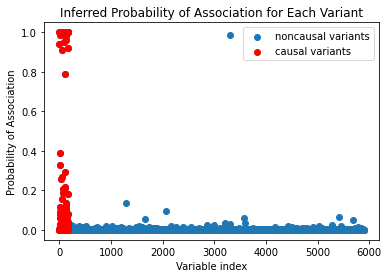

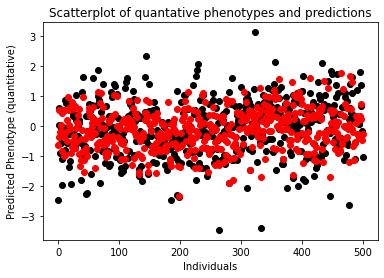

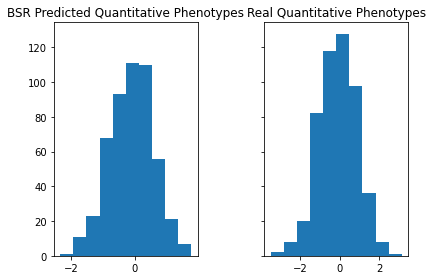

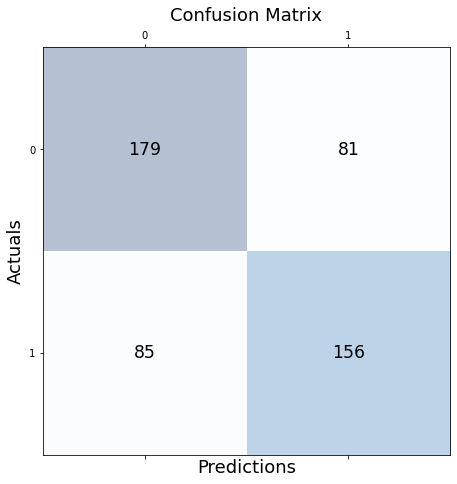

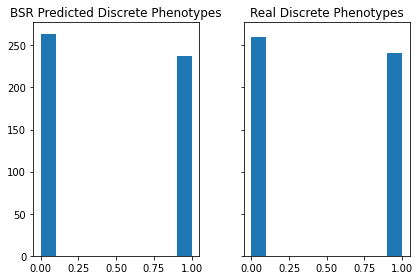

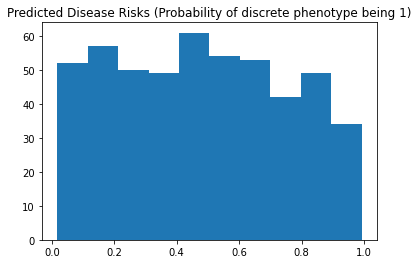

Bayesian Sparse Regression Mean Squared Error:  0.6447313820721914
Bayesian Sparse Regression Classification Accuracy:  0.6686626746506986
Bayesian Sparse Regression Classification F-1 Score:  0.6527196652719666
Neural Network Results


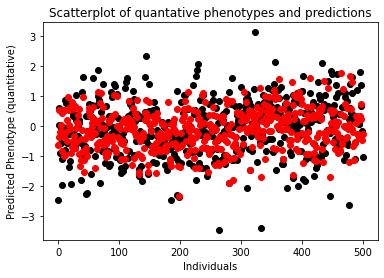

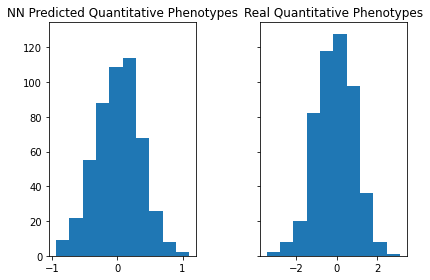

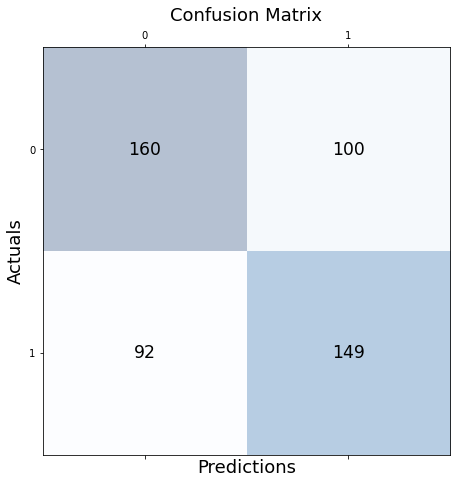

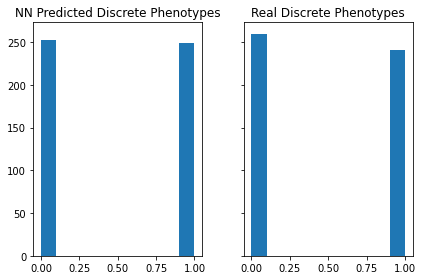

Neural Network Mean Squared Error:  0.7188412479419268
Neural Network Classification Accuracy:  0.6167664670658682
Neural Network Classification F-1 Score:  0.6081632653061225


In [18]:
### Then plot with Matplotlib library
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,accuracy_score, f1_score, confusion_matrix

print("Bayesian Sparse Regression Results")
############### Visualize variable association predictions ##########################
plt.scatter(np.arange(len(pips)), pips, label= "noncausal variants")
plt.scatter(causals, pips[causals], c="red", label="causal variants")
plt.xlabel("Variable index")
plt.ylabel("Probability of Association")
plt.legend()
plt.title("Inferred Probability of Association for Each Variant")
plt.show()

####### Quantitative Scatterplot #################
plt.scatter(np.arange(len(quantPheno)), quantPheno, c="black", label="Ground-truth")
plt.scatter(np.arange(len(quantPredictions)), quantPredictions, c="red", label="Predicted")
plt.xlabel("Individuals")
plt.ylabel("Predicted Phenotype (quantitative)")
plt.title("Scatterplot of quantative phenotypes and predictions")
plt.show()

############ Histogram of Quantitative Predictions ##############
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(quantPredictions, bins=10)
axs[1].hist(quantPheno, bins=10)
axs[0].title.set_text('BSR Predicted Quantitative Phenotypes')
axs[1].title.set_text('Real Quantitative Phenotypes')
plt.show()

############ Confusion Matrix ##############
conf_matrix=confusion_matrix(discretePheno, DiscretePredictions)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

############ Histogram of Discrete Predictions ##############
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(DiscretePredictions, bins=10)
axs[1].hist(discretePheno, bins=10)
axs[0].title.set_text('BSR Predicted Discrete Phenotypes')
axs[1].title.set_text('Real Discrete Phenotypes')
plt.show()

############ Histogram of Disease Risk ##############
# We can set the number of bins with the `bins` kwarg
plt.hist(DiscreteProbs, bins=10)
plt.title('Predicted Disease Risks (Probability of discrete phenotype being 1)')
plt.show()     

#For regression task:
print("Bayesian Sparse Regression Mean Squared Error: ", mean_squared_error(quantPheno, quantPredictions))
#For classification task:
print("Bayesian Sparse Regression Classification Accuracy: ", accuracy_score(discretePheno, DiscretePredictions))
print("Bayesian Sparse Regression Classification F-1 Score: ", f1_score(discretePheno, DiscretePredictions))
#Note: These numbers are a little bit better when averaged over 20-30 simulations, this instance might be picking correlated SNPs for causals

print("Neural Network Results")
################ Neural Network ############################
NNpredictions=np.genfromtxt("NNpredictions_quantChr22.txt", delimiter="\t" )
NNclassifications= np.argmax(np.genfromtxt("NNclassifications_quantChr22.txt", delimiter="\t" ), axis=1)

####### Quantitative Scatterplot #################
plt.scatter(np.arange(len(quantPheno)), quantPheno, c="black", label="Ground-truth")
plt.scatter(np.arange(len(NNpredictions)), quantPredictions, c="red", label="Predicted")
plt.xlabel("Individuals")
plt.ylabel("Predicted Phenotype (quantitative)")
plt.title("Scatterplot of quantative phenotypes and predictions")
plt.show()

# ############ Histogram ##############
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(NNpredictions, bins=10)
axs[1].hist(quantPheno, bins=10)
axs[0].title.set_text('NN Predicted Quantitative Phenotypes')
axs[1].title.set_text('Real Quantitative Phenotypes')
plt.show()

############ Confusion Matrix ##############
conf_matrix=confusion_matrix(discretePheno, NNclassifications)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

############ Histogram of Discrete Predictions ##############
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(NNclassifications, bins=10)
axs[1].hist(discretePheno, bins=10)
axs[0].title.set_text('NN Predicted Discrete Phenotypes')
axs[1].title.set_text('Real Discrete Phenotypes')
plt.show()

#For regression task:
print("Neural Network Mean Squared Error: ", mean_squared_error(quantPheno, NNpredictions))
#For classification task:
print("Neural Network Classification Accuracy: ", accuracy_score(discretePheno, NNclassifications))
print("Neural Network Classification F-1 Score: ", f1_score(discretePheno, NNclassifications))
#Note: These numbers are a little bit better when averaged over 20-30 simulations, this instance might be picking correlated SNPs for causals


### Notices

THIS NOTEBOOK HAS JUST A SAMPLE CODES. MICROSOFT DOES NOT CLAIM ANY OWNERSHIP ON THESE CODES AND LIBRARIES.
MICROSOFT PROVIDES THIS NOTEBOOK AND SAMPLE USE OF ML LIBRARIES ON AN “AS IS” BASIS. DATA OR ANY MATERIAL ON THIS NOTEBOOK. MICROSOFT MAKES NO WARRANTIES, EXPRESS OR IMPLIED, GUARANTEES OR CONDITIONS WITH RESPECT TO YOUR USE OF THIS NOTEBOOK. TO THE EXTENT PERMITTED UNDER YOUR LOCAL LAW, MICROSOFT DISCLAIMS ALL LIABILITY FOR ANY DAMAGES OR LOSSES, INCLUDING DIRECT, CONSEQUENTIAL, SPECIAL, INDIRECT, INCIDENTAL OR PUNITIVE, RESULTING FROM YOUR USE OF THIS NOTEBOOK.

Credits: Pinar Demetci-Research intern

##### -END OF NOTEBOOK - 